In [3]:
from mne import io
from sklearn.utils import shuffle
import scipy.signal
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import json

import pickle
import gzip

def filt_coef(order, cutoff, filt_type, sampleRate):
    Nq = sampleRate//2
    Wn = cutoff / Nq
    b, a = scipy.signal.butter(order, Wn, filt_type)
    return b, a

In [6]:
home = r"..\data\data3_attention\raw"

In [7]:
# Get all edf files under this directory

ls = os.listdir(home)
newls = []
for fname in ls:
    if fname.endswith('.edf'):
        newls.append(fname)
newls

['0402_65.edf',
 '0402_66.edf',
 '0402_67.edf',
 '0402_68.edf',
 '0402_69.edf',
 '0402_85.edf',
 '0402_86.edf',
 '0402_87.edf',
 '0402_88.edf',
 '0402_89.edf',
 '0801_85.edf',
 '0801_86.edf',
 '0801_87.edf',
 '0801_88.edf',
 '0801_89.edf',
 '0901_65.edf',
 '0901_66.edf',
 '0901_67.edf',
 '0901_68.edf',
 '0901_69.edf',
 '0901_85.edf',
 '0901_86.edf',
 '0901_87.edf',
 '0901_88.edf',
 '0901_89.edf',
 '1002_65.edf',
 '1002_66.edf',
 '1002_67.edf',
 '1002_68.edf',
 '1002_69.edf',
 '1002_85.edf',
 '1002_86.edf',
 '1002_87.edf',
 '1002_88.edf',
 '1002_89.edf',
 '1101_65.edf',
 '1101_66.edf',
 '1101_67.edf',
 '1101_68.edf',
 '1101_69.edf',
 '1101_85.edf',
 '1101_86.edf',
 '1101_87.edf',
 '1101_88.edf',
 '1101_89.edf']

In [13]:
# Or uncomment this block to customize the files you want to include in your dataset

newls = [
    '0401_11.edf',
    '0401_12.edf',
    '0401_13.edf'
]

In [42]:
window_length = 1000 # length of the input array needed
sampleRate = 1000 # sample rate of raw data

datacuts = []
labels = []
threshold = 700 # This is to reduce noise in data: cut all the data points beyond [-threshold, threshold]

for fname in newls:
    fpath = os.path.join(r"..\data\data3_attention\raw", fname)

    r = io.read_raw_edf(fpath)
    r.drop_channels(['ECG', 'VEOG', 'HEOG'])
    unfilter_datacut = r.load_data()[['Fp1','Fp2']][0]
    unfilter_datacut = np.array(unfilter_datacut)
    
    # filter the data
    b, a = filt_coef(2, 30, 'lowpass', sampleRate)
    d, c = filt_coef(5, 1, 'highpass', sampleRate)    
    unfilter_datacut[0] = scipy.signal.filtfilt(b, a, unfilter_datacut[0])
    unfilter_datacut[1] = scipy.signal.filtfilt(b, a, unfilter_datacut[1])
    unfilter_datacut[0] = scipy.signal.filtfilt(d, c, unfilter_datacut[0])
    unfilter_datacut[1] = scipy.signal.filtfilt(d, c, unfilter_datacut[1])
    
    
    # cut all the data points beyond [-threshold, threshold]
    unfilter_datacut = np.transpose(unfilter_datacut)
    print(unfilter_datacut.shape)
    datacut = []
    for i,j in unfilter_datacut:
        if abs(i) <= threshold and abs(j) <= threshold:
            datacut.append([i,j])
    datacut = np.transpose(np.array(datacut))
    print("datacut:", datacut.shape)

    
    # normalise to [0, 1]
    datacut[0] = datacut[0] - min(datacut[0])
    datacut[1] = datacut[1] - min(datacut[1])
    scale = 2 * threshold
    datacut[0] = datacut[0] / scale
    datacut[1] = datacut[1] / scale

    # resample the array to 500Hz
    datacut = datacut[:, ::2]

    
    # cut the long array to short ones, length: 2s.
    l = datacut.shape[1] # data points
    n = int(l / window_length) # number of cuts
    # Triple classification: L/M/H
    label = int(fname.split(".")[0][-1]) - 1.0 # 0,1,2
    for start in [i * window_length for i in list(range(n))]:
        arr = datacut[:, start: start + window_length]
        datacuts.append(arr)
        labels.append(label)

    print(len(datacuts))


Extracting EDF parameters from D:\GitHub\EEG_fatigue\data\data3_attention\raw\0401_11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 557999  =      0.000 ...   557.999 secs...
(558000, 2)
datacut: (2, 554841)
277
Extracting EDF parameters from D:\GitHub\EEG_fatigue\data\data3_attention\raw\0401_12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 557999  =      0.000 ...   557.999 secs...
(558000, 2)
datacut: (2, 552803)
553
Extracting EDF parameters from D:\GitHub\EEG_fatigue\data\data3_attention\raw\0401_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 557999  =      0.000 ...   557.999 secs...
(558000, 2)
datacut: (2, 549894)
827


In [43]:
# shuffle the data
datacuts, labels = shuffle(datacuts, labels, random_state=0)

In [44]:
datacuts = np.array(datacuts)
datacuts.shape

(827, 2, 1000)

In [45]:
# count number of samples in each class to make sure it's balanced
from collections import Counter
d = Counter(labels)
d

Counter({2.0: 274, 0.0: 277, 1.0: 276})

In [46]:
labels[0:10]

[2.0, 0.0, 0.0, 0.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0]

In [47]:
labels = np.array(labels)
labels.shape

(827,)

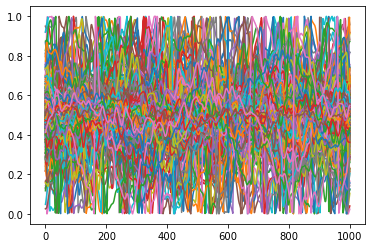

In [48]:
for i in range(len(labels)):
    plt.plot(datacuts[i][0])

In [ ]:
# save your dataset, remember to change the file name!

dataset = [datacuts, labels]

save_file = "..\\data\\data3_attention\\fatigue_sub1101_low_fp1fp2_2s_resampled500Hz.pkl"
with open(save_file, 'wb') as handle:
            # pickle.dump(dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(dataset, handle, protocol=2)
    print("saved:", save_file)